In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.integrate as integrate
from numba import jit,njit,vectorize, float64, int32
import numba as nb
import time as time
## ---------------- Mathplotlib settings ----------------
SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

<!-- ### Try an adaptive stepsize that is easy to control: 

We can try 
$$
   f(x)= (\Delta t_{\text{max}}-\Delta t_{\text{min}}) \left(1-\exp(- x R) \right)+ \Delta t_{\text{min}},
$$
with 
$$
   f'(x)= (\Delta t_{\text{max}}-\Delta t_{\text{min}}) R \exp(- x R).
$$
This is one example that is typically not based on the geometry of the problem but rather making the step smaller near the well of the potential. Alternatively, we could imagine a linear growth with a minimal value: 
$$
   f(x)= (\Delta t_{\text{max}}-\Delta t_{\text{min}}) R x+ \Delta t_{\text{min}},
$$
$$
   f'(x)= (\Delta t_{\text{max}}-\Delta t_{\text{min}}) R 
$$

Below, I plot those two examples of step sizes.  -->



### Overdamped Langevin Adaptive

Simulate the dynamics of 

$$
dx = F(x) dt + \sqrt{2} dW(t)
$$

using the modified sde : 
$$
dy = g(y)F(y) ds+ g'(y) ds + \sqrt{2 g(y)} dW(s)
$$

We use the system already extensively studied: 

$$
F(x)=-\nabla V(x) \\
V(x)= \frac{1}{2 x^2} +x^2\\
F(x)= -\frac{1}{x^3}+2x
$$

Ultimately we would like to use the geometry of the problem, such as using the absolute value of $ f(x) =\|-\nabla V(x)\| = \| -\frac{1}{x^3}+2x\|$. 
The idea is to use 
$$ g(x) = \frac{1}{F(x)} \\ 
 g(x) = \frac{1}{\|-\nabla V(x)\|} \\ 

g(x) = \frac{1}{ \|-\frac{1}{x^3}+2x\| }$$
and 
$$ g'(x) =\frac{- \|\frac{3}{x^4}+2\|}{\|-\frac{1}{x^3}+2x\|^2} $$


The issue is that we would also like to have some control regarding the minimum and maximum value taken by the time steps. Therefore, we can create a new function which bounds the value of $\frac{1}{\|-\nabla V(x)\|}$ such that the modified time $g(x)\Delta s$ stays bounded between $\Delta t_{min}=0.001$ and $\Delta t_{max}=0.1$. We follow the steps in Huang&Leimkuhler and set $m=\frac{\Delta t_{min}}{\Delta s}$ and $M= \frac{\Delta t_{max}}{\Delta s}$ and set the function: $f(x)= \|-\nabla V(x)\|$. We define $g^{-1}$, the inverse of the function $g(x) = \frac{1}{f(x)}$ as:
$$
g^{-1}(x) = \frac{\sqrt{ \|f(x)\|^2+m^2}}{\frac{1}{M}\sqrt{\|f(x)\|^2+m^2}+1},
$$
such that : 
$$
g(x) = \frac{\frac{1}{M}\sqrt{\|f(x)\|^2+m^2}+1}{\sqrt{ \|f(x)\|^2+m^2}} 
$$

One need to be carefull about the norm of the function $\|f(x)\| = \phi(f(x))$, where $\phi(x) = \|x\| = \sqrt{x^2}$, which should be written more carefully in this way: 
$$
\begin{aligned}
g(x) &= \frac{\frac{1}{M}\sqrt{\phi(f(x))^2+m^2}+1}{\sqrt{ \phi(f(x))^2+m^2}}\\
g(x) &= \frac{1}{M} + \frac{1}{\sqrt{ \phi(f(x))^2+m^2}}
\end{aligned}
$$

such that when we look for the derivative, we obtain: 
$$
    g'(x) = - \frac{\phi(f(x)) \frac{d\phi(f(x))}{dx}}{(f(x)^2 + m^2)^{3/2}}
$$
We have that:
$$
\begin{aligned}
\frac{d\phi(f(x))}{dx}  &= \frac{d\phi(f(x))}{df(x)} \frac{df(x)}{dx}  \\
\frac{d\phi(f(x))}{dx}  &= \frac{1}{2} \frac{2 f(x)}{\phi(f(x))} f'(x) \\
\frac{d\phi(f(x))}{dx}  &= \frac{f(x)}{\phi(f(x))} f'(x).
\end{aligned}
$$
resulting in : 
$$
    g'(x) = - \frac{ f(x)f'(x)}{(f(x)^2 + m^2)^{3/2}}
$$

We do have that : $\phi(f(x)) = \| f(x) \| = \sqrt{((1/x^3)-2x)^2}$, $f(x) = 1/x^3 - 2x$, $f'(x) = -(\frac{3}{x^4}+2)$, and  $\phi(f(x))^2 = \| f(x) \|^2 = \sqrt{((1/x^3)-2x)^2}^2 = f(x)^2$

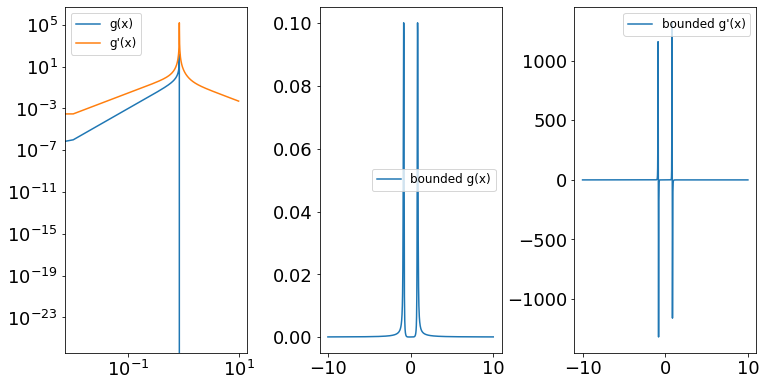

In [3]:
def g(x): 
    # value of function f, f' and f^2
    x3=np.power(x,3)
    f=(1/x3-2*x)
    fprime=-(3/(x3*x)+2)
    f2 = f*f

    gx = 1/f
    gxprime = -fprime/f2
    
    #return
    re=np.array([gx,gxprime])
    return re
    
def g4_plot(x,h,dtmin,dtmax):
    """
    Compute the value of the adaptive function choosen:
    x: float 
    """

    M=h/dtmin
    
    m=h/dtmax
    x3=np.power(x,3)

    # value of function f, f' and f^2
    f=(1/x3-2*x)
    fprime=-(3/(x3*x)+2)

    f2 = f*f

    #compute the value of phi(f(x)) = \sqrt{f(x)^2}
    phif = np.sqrt(f2)
    phif2 = f2*f2

    # value of m^2
    m2 = m*m

    #compute gx
    gx_den=np.sqrt(phif2+m2)
    gx_num = gx_den/M + 1 
    gx=gx_num/gx_den

    #compute gx prime 
    gxp_num=- f*fprime
    gxp_den = gx_den*gx_den*gx_den
    gxprime= gxp_num/gxp_den
    gxprime = np.round(gxprime,6)
    #return
    re=np.array([gx,gxprime])
    return re


fig, (ax1,ax2,ax3)= plt.subplots(1, 3,figsize=(12,6))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.1,right=0.9, top=0.9, wspace=0.4, hspace=0.4)
dt=0.01
dtbounds = np.array([0.0001,0.1])
dtmin=dtbounds[0]
dtmax = dtbounds[1]
x=np.arange(-10,10,0.01)
gx4_test = g4_plot(x,dt,dtmin,dtmax)

ax1.loglog(x,g(x)[0,::],label="g(x)")
ax1.loglog(x,g(x)[1,::],label="g'(x)")
ax2.plot(x,gx4_test[0,::]*dt,label="bounded g(x)")
ax3.plot(x,gx4_test[1,::],label="bounded g'(x)")
ax1.legend()
ax2.legend()
ax3.legend()

In [4]:
#%time ytest=y_compile = DW_sde_fast(1000,3,10,0.01,20) # compile the function
def plot_dist(y,tau,dt,n_samples,T,title,ax):
    ax.set_title(str(title)+", $\\tau$="+str(tau)+", h="+str(dt)+", \n N="+str(n_samples)+", T="+str(T))

    #Plot 1
    histogram,bins = np.histogram(y,bins=100,range=[-5,5], density=True)

    midx = (bins[0:-1]+bins[1:])/2
    histogram=(histogram/np.sum(histogram))
    ax.plot(midx,histogram,label='q-Experiment')

    rho = np.exp(- (U(midx)/tau))
    rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) 
    rho=(rho/np.sum(rho))*2
    rho=[rho[i] if i>50 else 0 for i in range(len(rho))]
    ax.plot(midx,rho,'--',label='Truth') 
    ax.legend()

<!-- We set up 3 files with the three different functions we discussed above; 
1. "infinitedoublewell_adaptive_gx1" uses $g(x)= (\Delta t_{\text{max}}-\Delta t_{\text{min}}) \left(1-\exp(- x R) \right)+ \Delta t_{\text{min}}$
2. "infinitedoublewell_adaptive_gx2" uses $g(x)= (\Delta t_{\text{max}}-\Delta t_{\text{min}}) R x+ \Delta t_{\text{min}}$
3. "infinitedoublewell_adaptive_gx3" uses $g(x) =  \frac{\frac{1}{M}(\|f(x)\|+m)+1}{\|f(x)\| + m}.$. -->
4. "infinitedoublewell_adaptive_gx4" uses $g(x) = \frac{\frac{1}{M}\sqrt{\|f(x)\|^2+m^2}+1}{\sqrt{ \|f(x)\|^2+m^2}}$

In [5]:
%run "/home/s2133976/OneDrive/ExtendedProject/codingUsingNumba/WeakSDEapproximation/numba code/infinitedoublewell_adaptivegx4.py"
%run "/home/s2133976/OneDrive/ExtendedProject/codingUsingNumba/WeakSDEapproximation/numba code/infinitedoublewell_nsample.py"

<Figure size 432x288 with 0 Axes>

Fistlty we need to make a quick visual check to make sure that each adaptive method seems to be converging towards the actual method of interest. 

In [6]:
%time ytest= IDW_nsample_ada4(10,1,0.1,np.array([0.01,0.1]))   # compile the function
%time y_nonada= IDW_nsample(10,1,1,1)

CPU times: user 997 ms, sys: 105 µs, total: 997 ms
Wall time: 993 ms
CPU times: user 583 ms, sys: 0 ns, total: 583 ms
Wall time: 396 ms


In [7]:
n_samples=10**4
T=100
dtnonada=0.01
tau=1
%time y_nonada= IDW_nsample(n_samples,T,dtnonada,tau)

CPU times: user 2min 49s, sys: 105 ms, total: 2min 50s
Wall time: 15.9 s


In [8]:
n_samples=10**4
dt=0.01
dtbounds = np.array([0.001,0.01])
%time y_adag4= IDW_nsample_ada4(n_samples,T,dt,dtbounds) 

CPU times: user 26min 37s, sys: 1.82 s, total: 26min 39s
Wall time: 2min 26s


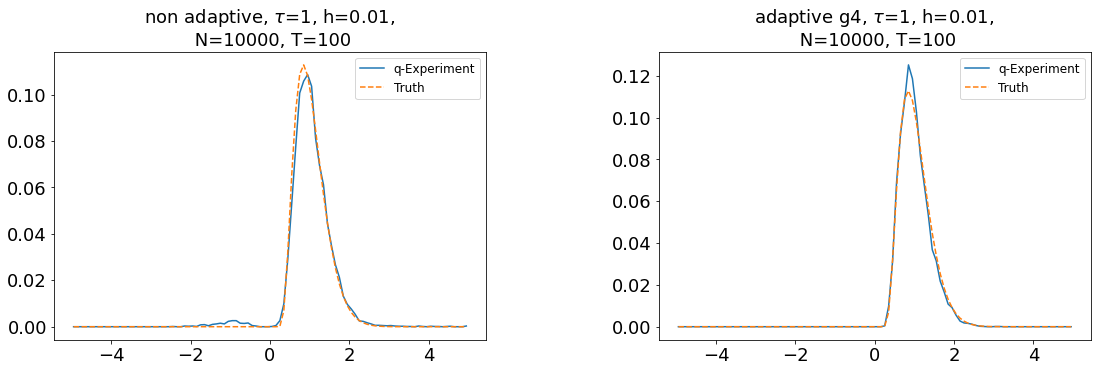

In [9]:
fig, ((ax1,ax2))= plt.subplots(1,2,figsize=(18,5))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plot_dist(y_nonada,tau,dtnonada,n_samples,T,"non adaptive",ax1)
plot_dist(y_adag4[::,0],tau,dt,n_samples,T,"adaptive g4",ax2)


Test the adaptive method with different values of $\Delta t$, generally, we need that $g'(x)$ stays bounded in order to obtain good results, see examples below: 

CPU times: user 27.8 s, sys: 33.9 ms, total: 27.8 s
Wall time: 2.55 s


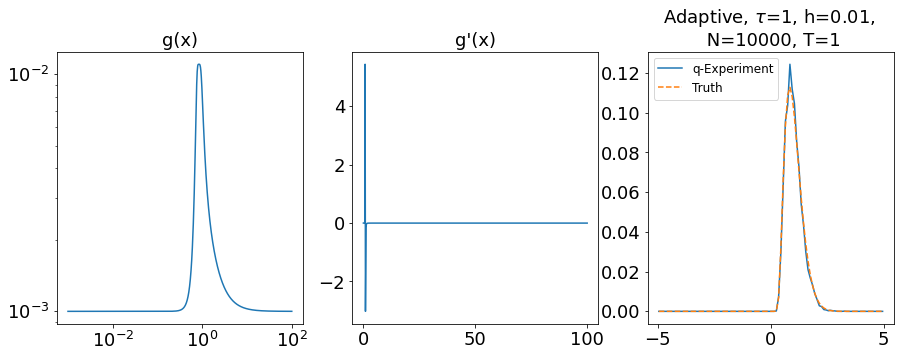

In [8]:
n_samples=10000
T=1
dtmax=0.01
dtbounds = np.array([0.001,dtmax])

## Figure set up 
fig, (ax1,ax2,ax3)= plt.subplots(1,3,figsize=(15,5))# plt.figure(figsize=(4,4))

## Plot the values of g and g'
dtmin=dtbounds[0]
dtmax = dtbounds[1]
x=np.arange(0.001,100,0.01)
gx4_test = g4_plot(x,dt,dtmin,dtmax)
ax1.loglog(x,gx4_test[0,::]*dt,label="g(x)")
ax1.set_title("g(x)")
ax2.plot(x,gx4_test[1,::],label="g(x)")
ax2.set_title("g'(x)")
## Compute the distribution 
%time y_adag4= IDW_nsample_ada4(n_samples,T,dt,dtbounds) 
plot_dist(y_adag4[::,0],tau,dt,n_samples,T,"Adaptive",ax3)



CPU times: user 5min 32s, sys: 194 ms, total: 5min 32s
Wall time: 30.6 s


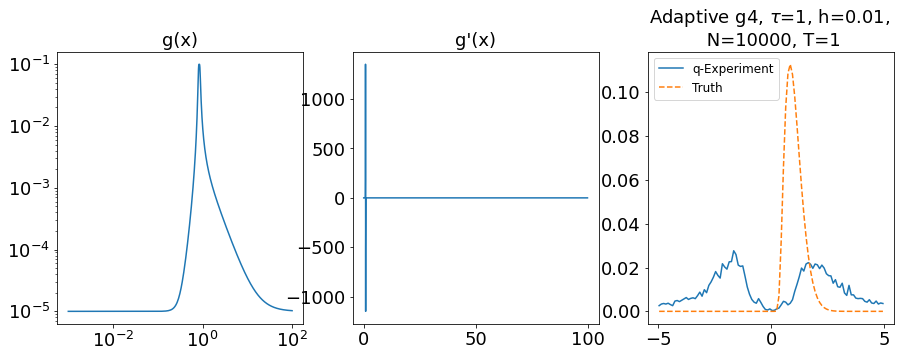

In [12]:
n_samples=10000
dt=0.01
tau=1
dtbounds = np.array([0.00001,0.1])

## Figure set up 
fig, (ax1,ax2,ax3)= plt.subplots(1,3,figsize=(15,5))# plt.figure(figsize=(4,4))

## Plot the values of g and g'
dtmin=dtbounds[0]
dtmax = dtbounds[1]
x=np.arange(0.001,100,0.01)
gx4_test = g4_plot(x,dt,dtmin,dtmax)
ax1.loglog(x,gx4_test[0,::]*dt,label="g(x)")
ax1.set_title("g(x)")
ax2.plot(x,gx4_test[1,::],label="g(x)")
ax2.set_title("g'(x)")
## Compute the distribution 
%time y_adag4= IDW_nsample_ada4(n_samples,T,dt,dtbounds) 
plot_dist(y_adag4[::,0],tau,dt,n_samples,T,"Adaptive g4",ax3)

CPU times: user 10min, sys: 376 ms, total: 10min
Wall time: 52.8 s


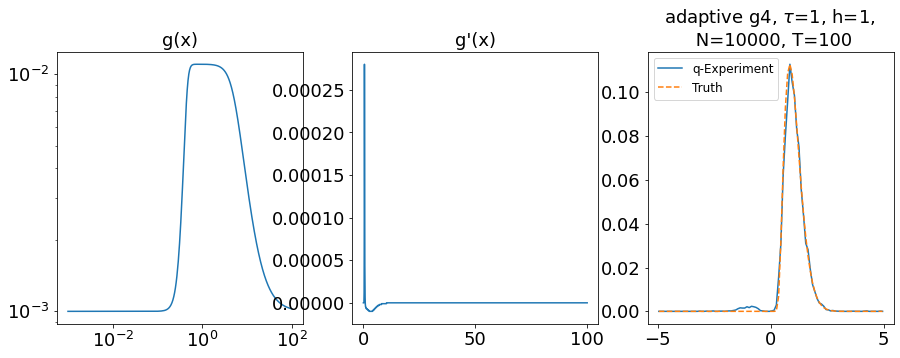

In [33]:
n_samples=10000
dt=1
dtbounds = np.array([0.001,0.01])
## Figure set up 
fig, (ax1,ax2,ax3)= plt.subplots(1,3,figsize=(15,5))# plt.figure(figsize=(4,4))

## Plot the values of g and g'
dtmin=dtbounds[0]
dtmax = dtbounds[1]
x=np.arange(0.001,100,0.01)
gx4_test = g4_plot(x,dt,dtmin,dtmax)
ax1.loglog(x,gx4_test[0,::]*dt,label="g(x)")
ax1.set_title("g(x)")
ax2.plot(x,gx4_test[1,::],label="g(x)")
ax2.set_title("g'(x)")
## Compute the distribution 
%time y_adag4= IDW_nsample_ada4(n_samples,T,dt,dtbounds) 
plot_dist(y_adag4[::,0],tau,dt,n_samples,T,"adaptive g4",ax3)

Now we would like to compare our method against the normal one, to see whether it is a more accurate method. This is interesting to get some results on the Langevin adaptive method, however we can not vary $\tau$ as it is now fixed to $\tau = 1$, so what we can do is vary $\Delta t$ or change the type of function $g(x)$ we are looking at. This should be enough on this for now. 

### Get a measure of the observabe with regards to different number of time steps taken

To do so, we look at the adaptive step-size and vary it to establish different cost to run the algorithm. A cost is the number of evaluations required to obtain the solutions. Each paths will triggered a different adaptive step size, so if we run the code for n_samples times, we would need to have a total number of paths allowed per n samples. 

We also need to vary the function $g(x)$ while keeping the value of $g'(x)$ bounded. 

0.001
0.01
0.001
0.015
0.001
0.02
0.001
0.025


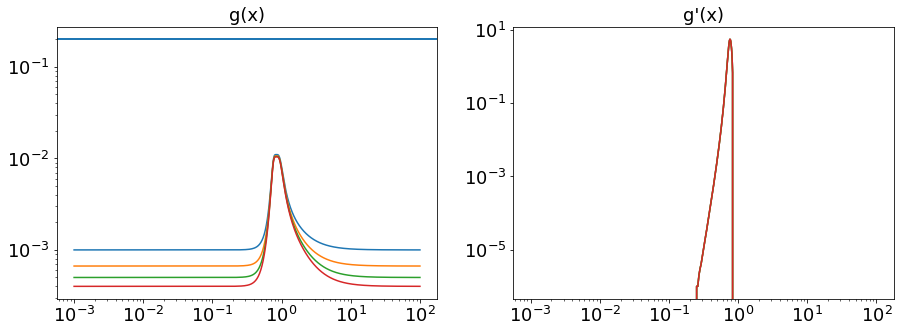

In [145]:
fig, (ax1,ax2)= plt.subplots(1,2,figsize=(15,5))# plt.figure(figsize=(4,4))

## Plot the values of g and g'
x=np.arange(0.001,100,0.01)

for n in range(10,30,5):
    dtmax = n*0.001
    dtbounds=[0.001,dtmax]    
    dtmin=dtbounds[0]
    dtmax=dtbounds[1]
    print(dtmin)
    print(dtmax)

    gx4_test = g4_plot(x,dtmax,dtmin,dtmax)
    ax1.loglog(x,gx4_test[0,::]*dt,label="g(x)")
    ax1.axhline(y=0.2)
    ax1.set_title("g(x)")
    ax2.loglog(x,gx4_test[1,::],label="g(x)")
    ax2.set_title("g'(x)")

Below I evaluate the adaptive step size using different value of $\Delta t_{min}$, $\Delta t_{max}$ and see how many steps evaluations results in the methods. It is not straightfoward to vary $g(x)$ such that the number of force evaluations increases. 

[0.1        0.31622777]
[0.01 0.1 ]
[0.001      0.03162278]
[0.0001 0.01  ]
[1.00000e-05 3.16228e-03]
[1.e-06 1.e-03]


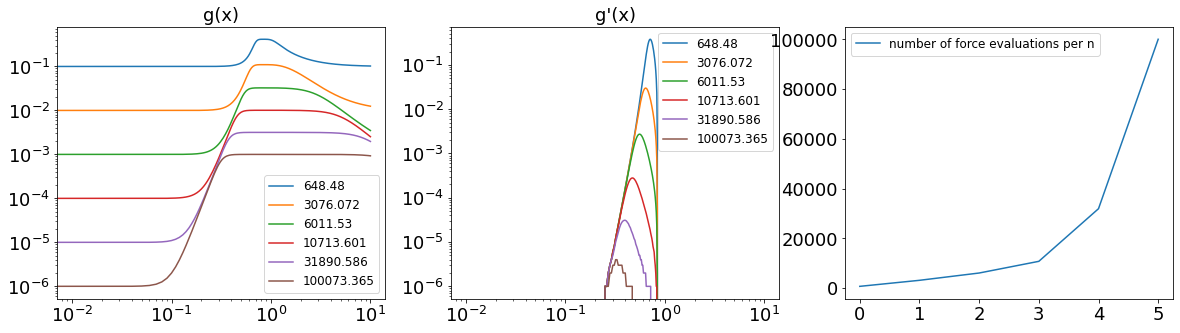

In [8]:
## Get an idea of how much mean steps required 
n_samples=10**3
T=100
y_sol=[] #solution
t_sol=[] #count per run
t_plot=[] #mean count per sample

fig, (ax1,ax2,ax3)= plt.subplots(1,3,figsize=(20,5))# plt.figure(figsize=(4,4))

for ii in range(1,7,1):
    #set up new bounds
    dt = 1
    dtbounds=np.power([0.01,0.1],ii/2)
    dtbounds_n =np.round(dtbounds,8)
    print(dtbounds_n)
    #compute the solution
    yt_langevin_n=IDW_nsample_ada4(n_samples,T,dt,dtbounds_n) 
    y_sol.append(yt_langevin_n[::,0])

    #evaluate the mean number of steps taken
    mean_eval = np.mean(yt_langevin_n[::,1])
    t_plot.append(mean_eval)

    # #plot the look of the function g(x)
    gx4_test = g4_plot(x,dt,dtbounds_n[0],dtbounds_n[1])
    ax1.loglog(x,gx4_test[0,::]*dt,label=str(mean_eval))
    ax1.set_title("g(x)")
    ax1.legend()

    ax2.loglog(x,gx4_test[1,::]*dt,label=str(mean_eval))
    ax2.set_title("g'(x)")
    ax2.legend()

#plot the mean number of steps taken
ax3.plot(t_plot,"-",label="number of force evaluations per n")
ax3.legend()

Above, I have computed the solutions for different values of $\Delta t_{min}$, $\Delta t_{max}$ and this allows to increase the number of force evaluations required. I have plotted the values of $g'(x)$ and it seems that the function stays bounded. I will now plot the histograms of the solutions with the ADAPTIVE METHOD to make sure that they make sens. 

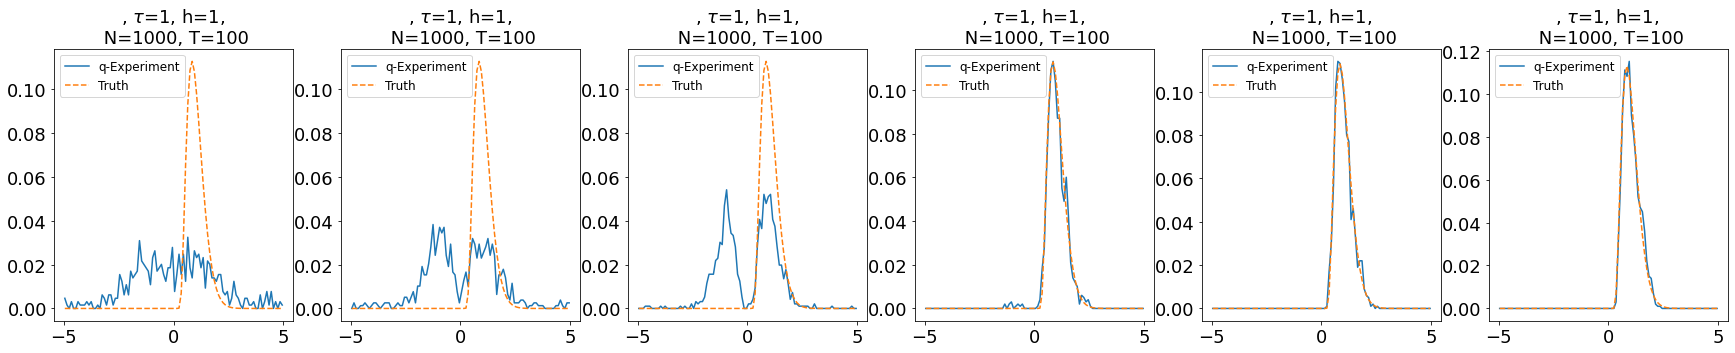

In [9]:
fig, (axs)= plt.subplots(1,len(t_plot),figsize=(30,5))# plt.figure(figsize=(4,4))

for ii in range(len(y_sol)):
    yi=y_sol[ii]
    
    plot_dist(yi,tau,dt,n_samples,T,"",axs[ii])
    

Now try and compute the observable of interest per solution 

In [10]:
def nesc_ysol(y_sol,b):
    """
    Function to establish the proportion of escaping trajectories
    Input :
    ------
    y_sol: list of list of sol per run
        number of samples generated
    b: int
        Boundary selected
    """
    # number of escaping trajectories
    nesc_list=[]
    #run through the different values of tau 
    for i in range(len(y_sol)):
        yi = y_sol[i]
        #compute the proportion of escaping trajectory
        res = len(yi[yi<0])+len(yi[yi>b])
        res = res/len(yi)
        nesc_list.append(res)
        
    return(nesc_list)

Text(0.5, 0.98, 'Adaptive')

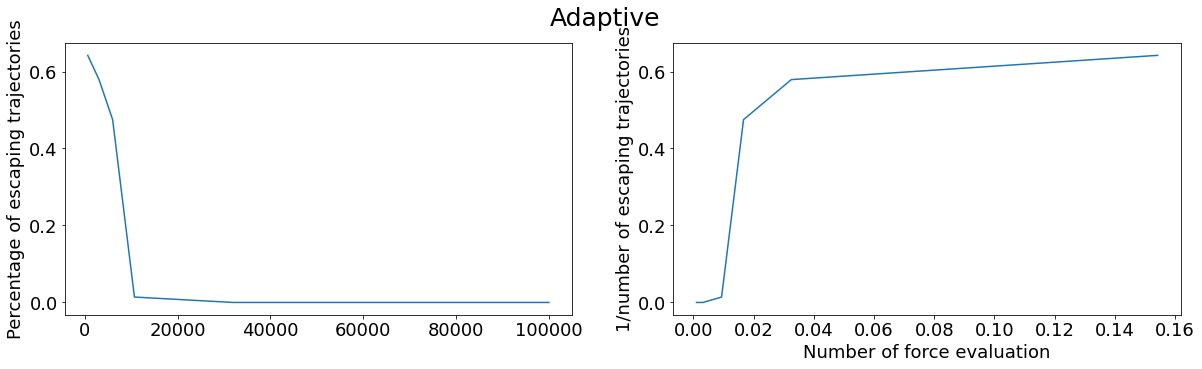

In [11]:
nesc=nesc_ysol(y_sol,10)

fig, (ax1,ax2)= plt.subplots(1,2,figsize=(20,5))# plt.figure(figsize=(4,4))
ax1.plot(t_plot,nesc)
ax1.set_ylabel("Percentage of escaping trajectories")
ax2.set_xlabel("Number of force evaluation")

ax2.plot(T*np.power(t_plot,-1),nesc)
ax2.set_ylabel("1/number of escaping trajectories")
ax2.set_xlabel("Number of force evaluation")

fig.suptitle("Adaptive")


Results are mitigated on the observable. One can try and compute the error comparison with the true distribution. The true distribution is: 
$$
\rho_\infty(t) = \exp(-\nabla V(x)) 
$$

To compare to the simulated solution, I want to establish bins and compute the diffference between the proportion of simulated path falling into a bin and the true weighted bin. 

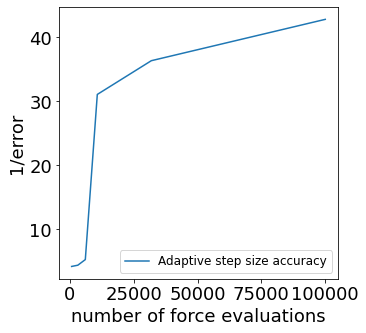

In [12]:
error_ada_list= []
for i in range(len(y_sol)):
    #Plot 1
    histogram,bins = np.histogram(y_sol[i],bins=100,range=[-5,5], density=True)

    midx = (bins[0:-1]+bins[1:])/2
    histogram=(histogram/np.sum(histogram))
    # ax.plot(midx,histogram,label='q-Experiment')

    rho = np.exp(- (U(midx)/tau))
    rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) 
    rho=(rho/np.sum(rho))*2
    rho=[rho[i] if i>50 else 0 for i in range(len(rho))]

    errori=np.sqrt(np.sum(np.power(rho-histogram,2)))
    error_ada_list.append(errori)

fig, (ax1)= plt.subplots(1,1,figsize=(5,5))# plt.figure(figsize=(4,4))
ax1.plot(t_plot,np.power(error_ada_list,-1),label="Adaptive step size accuracy")
ax1.set_ylabel("1/error")
ax1.set_xlabel("number of force evaluations")
ax1.legend()


To compare this result against the non adaptive stepsize method, we take the average value of of steps evaluation (so over the $n_\text{samples}=10000$ runs, how many steps one path take on average. Then with this force evaluation reserve, I run the Euler Maruyama method and compare results against one an other.

In [23]:
#compile the non adaptive - aka Euler Maruyama method
%time IDW_nsampleN(1,1,10,1)


CPU times: user 116 ms, sys: 0 ns, total: 116 ms
Wall time: 12.8 ms


array([1.9073234])

In [15]:
# Run the non adaptive simple euler maruyama
n_samples=10**4
T=10
tau=1
y_nonada_list=[]

# IDW_nsample(n_samples,T,dt,tau)
# list_dt=[0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]
list_dt=T*np.power(t_plot,-1)
for jj in range(len(list_dt)):
    dti = list_dt[jj]
    y_nonada=IDW_nsample(n_samples,T,dti,tau)
    y_nonada_list.append(y_nonada)

Now we look at the solutions to see whether they make sens?

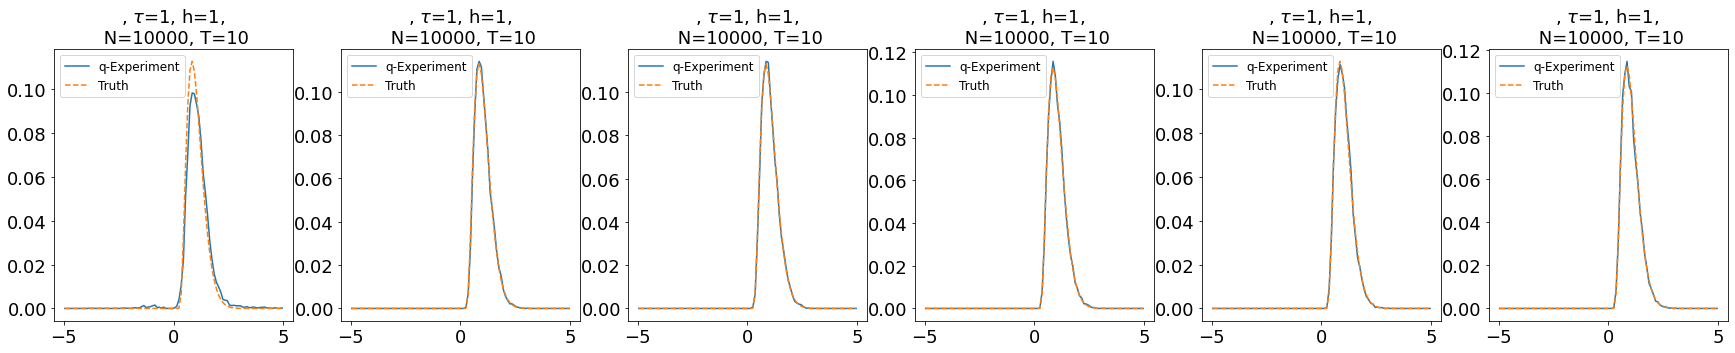

In [16]:
fig, (axs)= plt.subplots(1,len(list_dt),figsize=(30,5))# plt.figure(figsize=(4,4))
for ii in range(len(y_nonada_list)):
    yi=y_nonada_list[ii]
    plot_dist(yi,tau,dt,n_samples,T,"",axs[ii])

Now that we have obtained results on the solutions with equal computational force (sort of) we can compare the results using the observable of interest. 

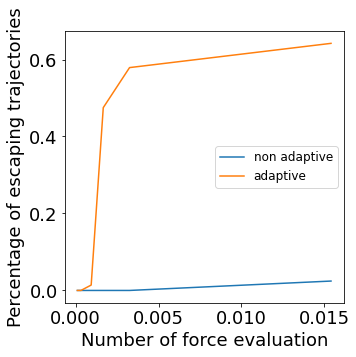

In [17]:
## Compare results 
## compute the number of escaping trajectories with the non adaptive time steps
nesc_nonada=nesc_ysol(y_nonada_list,10)

fig, (ax1)= plt.subplots(1,1,figsize=(5,5))# plt.figure(figsize=(4,4))
ax1.plot(list_dt,nesc_nonada,label="non adaptive")
ax1.set_ylabel("Percentage of escaping trajectories")
ax1.set_xlabel("Number of force evaluation")
ax1.legend()
# fig.suptitle("Non adaptive")

ax1.plot(list_dt,nesc,label="adaptive")
ax1.set_ylabel("Percentage of escaping trajectories")
ax1.set_xlabel("Number of force evaluation")
ax1.legend()

Now we can compute the error on each solution

In [18]:
error_nonada_list = []
for i in range(len(y_nonada_list)):
    #Plot 1
    histogram,bins = np.histogram(y_nonada_list[i],bins=100,range=[-5,5], density=True)
    midx = (bins[0:-1]+bins[1:])/2
    histogram=(histogram/np.sum(histogram))
    # ax.plot(midx,histogram,label='q-Experiment')

    rho = np.exp(- (U(midx)/tau))
    rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) 
    rho=(rho/np.sum(rho))*2
    rho=[rho[i] if i>50 else 0 for i in range(len(rho))]

    errori=np.sqrt(np.sum(np.power(rho-histogram,2)))
    error_nonada_list.append(errori)


Text(0.5, 0.98, 'Efficiency of the solutions')

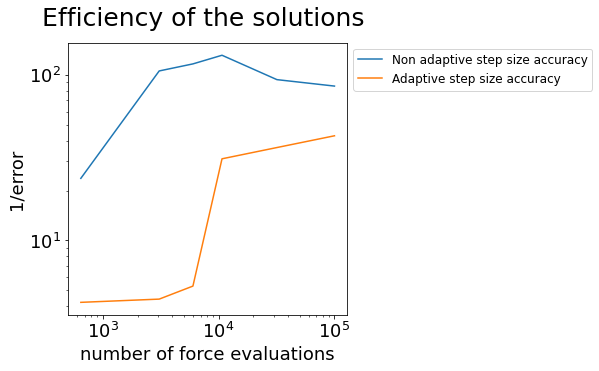

In [21]:
fig, (ax1)= plt.subplots(1,1,figsize=(5,5))# plt.figure(figsize=(4,4))
ax1.loglog(t_plot,np.power(error_nonada_list,-1),label="Non adaptive step size accuracy")
ax1.set_ylabel("1/error")
ax1.loglog(t_plot,np.power(error_ada_list,-1),label="Adaptive step size accuracy")
ax1.set_xlabel("number of force evaluations")
ax1.legend(bbox_to_anchor=[1, 1])
fig.suptitle("Efficiency of the solutions")